## Imports and constants

In [ ]:
!pip install basemap

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca as gca
from matplotlib.pyplot import grid as grid
from mpl_toolkits.basemap import Basemap
import math
import scipy
from scipy import integrate
from scipy.ndimage import rotate
%matplotlib inline

In [240]:
G = 6.673 * 1e-11
M = 5.972 * 1e24
radius = 6371000
ISS_height = 437*1e3
ISS_velocity = 7654
ISS_time = 90*60

In [3]:
Oz = [0, 0, 1]

In [212]:
def get_orbit_n(r, orbital_inclination, solution_one=False):
    phi = orbital_inclination * math.pi / 180
    z = math.cos(phi)

    p1 = -r[1] / r[0]
    p2 = -z * r[2] / r[0]
    
    a = p1 ** 2 + 1
    b = 2 * p1 * p2
    c = p2 ** 2 - math.sin(phi) ** 2
    y1 = ((-b + math.sqrt(b ** 2 - 4 * a * c)) / (2 * a))
    y2 = ((-b - math.sqrt(b ** 2 - 4 * a * c)) / (2 * a))

    x1 = p1 * y1 + p2
    x2 = p1 * y2 + p2

    n1 = np.array([x1, y1, z])
    n2 = np.array([x2, y2, z])

    if solution_one:
        return n1
    return n2

In [171]:
def odefun(x, t):
    # t, x = a[:3], a[3:]
    # print(t)
    # print(x)
    return np.array([x[3:6], -G*M*x[0:3] / ((np.linalg.norm(x[0:3]))**3)]).reshape(-1)

## Making rotating Earth gif

KeyboardInterrupt: 

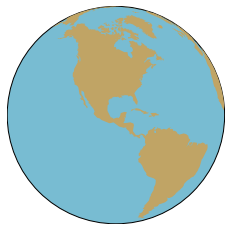

In [233]:
plt.ion()
fig = plt.figure(figsize=(9,6))

# set the latitude angle steady, and vary the longitude. You can also reverse this to
# create a rotating globe latitudinally as well
lat_viewing_angle = [20.0,20.0]
lon_viewing_angle = [-180,180]
rotation_steps = 150
lat_vec = np.linspace(lat_viewing_angle[0],lat_viewing_angle[0],rotation_steps)
lon_vec = np.linspace(lon_viewing_angle[0],lon_viewing_angle[1],rotation_steps)

# for making the gif animation
gif_indx = 0

# define color maps for water and land
ocean_map = (plt.get_cmap('ocean'))(210)
cmap = plt.get_cmap('gist_earth')

# loop through the longitude vector above
for pp in range(0, len(lat_vec)):
    plt.cla()
    m = Basemap(projection='ortho', lat_0=lat_vec[pp], lon_0=lon_vec[pp])
    
    # coastlines, map boundary, fill continents/water, fill ocean, draw countries
    m.drawmapboundary(fill_color=ocean_map)
    m.fillcontinents(color=cmap(200), lake_color=ocean_map)
    m.drawcoastlines()
    m.drawcountries()

    #show the plot, introduce a small delay to allow matplotlib to catch up
    # iterate to create the GIF animation
    gif_maker('basemap_rotating_globe.gif','./png_dir/',gif_indx,len(lat_vec)-1,dpi=90)
    gif_indx += 1

## Initialize params

In [241]:
cords = [-43.07, -61.50]
orbital_inclination = 51.6

In [242]:
North = cords[0] * math.pi / 180
East = cords[1] * math.pi / 180

## Solution

In [243]:
init_pos = np.array([math.cos(North)*math.cos(East),
                     math.cos(North) * math.sin(East),
                     math.sin(North)])

In [244]:
orbit_norm = get_orbit_n(init_pos, orbital_inclination)
tau = np.cross(orbit_norm, init_pos) # + 0.5 * orbit_norm

r0 = init_pos*(radius + ISS_height)
v0 = tau * ISS_velocity

In [325]:
tspan = np.linspace(0, int(ISS_time), 10 ** 7)
x0 = np.array(r0 + v0)
x0 = np.concatenate((r0, v0), axis=None)

x = scipy.integrate.odeint(odefun, x0, tspan, rtol=1e-13, atol=1e-14)
trajectory = x[:, 0:3]

In [326]:
x.shape

(10000000, 6)

In [327]:
trajectory.shape

(10000000, 3)

In [328]:
trajectory_corrected = np.zeros_like(trajectory)
for i in range(len(tspan)):
    current_time = tspan[i]
    angle_Earth_rotation = -2 * math.pi * current_time / (24 * 60 * 60)
    r = R.from_rotvec(angle_Earth_rotation * np.array([0, 0, 1]))
    current_point = trajectory[i, :]
    current_point_corrected = r.apply(current_point)
    trajectory_corrected[i, :] = current_point_corrected

In [ ]:
fig = plt.figure(figsize=(8, 6), dpi=80)

ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
ax.plot(tspan, x[:, 0:3])
ax1.plot(tspan, x[:, 3:6])

# plt.plot(tspan, x[:, 3:6])

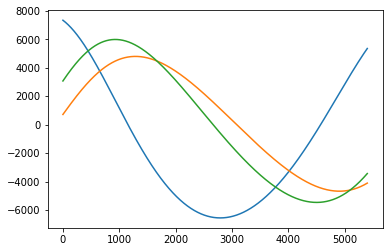

In [330]:
fig = plt.figure()
plt.plot(tspan, x[:, 3:6])

(-8000000.0, 8000000.0)

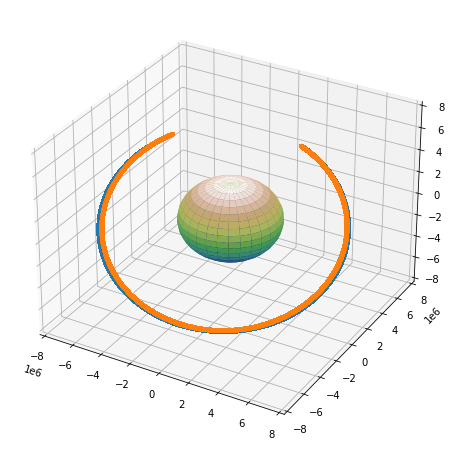

In [319]:
fig = plt.figure(figsize=(20, 8))

ax = fig.add_subplot(projection='3d')

u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v) * radius / 2
y = np.sin(u) * np.sin(v) * radius / 2
z = np.cos(v) * radius / 2
ocean_map = (plt.get_cmap('ocean'))(210)
cmap = plt.get_cmap('gist_earth')
my_map = Basemap(projection='ortho', lat_0=0, lon_0=0, resolution='l', area_thresh=1000.0)
# my_map.bluemarble()
# my_map.etopo()
    
ax.plot_surface(x, y, z, cmap=plt.get_cmap('gist_earth'))

ax.scatter(trajectory_corrected[:, 0], -trajectory_corrected[:, 1], -trajectory_corrected[:, 2],
           'r', linewidths=.01)

ax.scatter(trajectory[:, 0], -trajectory[:, 1], -trajectory[:, 2],
           'r', linewidths=.01)


ax.scatter(0, 0, 0, 'o')

ax.set_zlim(-8e6, 8e6)
ax.set_xlim(-8e6, 8e6)
ax.set_ylim(-8e6, 8e6)

In [322]:
i = 1
min(trajectory_corrected[:, i]), max(trajectory_corrected[:, i])

(-4370691.220399095, 5927379.021983789)